In [ ]:
import yfinance as yf
import statsmodels 
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import pandas as pd
import nasdaqdatalink as ndl
plt.style.use('seaborn-darkgrid')

In [3]:
ticker = 'SPY'
spyx = yf.download(ticker, start = '2014-01-01' , end ='2019-12-31')
spyx = pd.DataFrame(spyx)

[*********************100%***********************]  1 of 1 completed


In [4]:
effr = ndl.get("FRED/DFF", start_date = '2014-01-01' , end_date ='2019-12-31')
effr


,Value
Date,
2014-01-01,0.07
2014-01-02,0.08
2014-01-03,0.08
2014-01-04,0.08
2014-01-05,0.08
...,...
2019-12-27,1.55
2019-12-28,1.55
2019-12-29,1.55


In [5]:

spyx['Return'] = spyx['Adj Close'].pct_change()
spyx['Excess Return'] = spyx['Return'] - (effr['Value']/(100*252))
spyx['Daily interest rate'] = effr['Value']/(100*252)

In [6]:
#technical analysis strategy using MACD, RSI, and Bollinger bands
train_set_len = int(len(spyx)*0.7)
spy_train = spyx[:train_set_len]
spy_test = spyx[train_set_len:]

#MACD
def signals(spy):
    spy['MACD'] = spy['Adj Close'].ewm(span=12, adjust=False).mean() - spy['Adj Close'].ewm(span=26, adjust=False).mean()
    spy['Signal Line'] = spy['MACD'].ewm(span=9, adjust=False).mean()
    spy['MACD Signal'] = np.where(spy['MACD'] > spy['Signal Line'], 1, 0)
    spy['MACD Signal'] = np.where(spy['MACD'] < spy['Signal Line'], -1, spy['MACD Signal'])
    spy['MACD Signal'] = np.where(spy['MACD'].isnull(), 0, spy['MACD Signal'])

    #RSI

    spy['RSI'] = spy['Excess Return'].rolling(14).apply(lambda x: 100 - 100/(1+np.sum(x[x>0])/np.sum(x[x<0])))
    spy['RSI Signal'] = np.where(spy['RSI'] > 70, -1, 0)
    spy['RSI Signal'] = np.where(spy['RSI'] < 30, 1, spy['RSI Signal'])
    spy['RSI Signal'] = np.where(spy['RSI'].isnull(), 0, spy['RSI Signal'])
    #Bollinger Bands

    spy['Bollinger Upper'] = spy['Adj Close'].rolling(20).mean() + 2*spy['Adj Close'].rolling(20).std()
    spy['Bollinger Lower'] = spy['Adj Close'].rolling(20).mean() - 2*spy['Adj Close'].rolling(20).std()
    spy['Bollinger Signal'] = np.where(spy['Adj Close'] > spy['Bollinger Upper'], -1, 0)
    spy['Bollinger Signal'] = np.where(spy['Adj Close'] < spy['Bollinger Lower'], 1, spy['Bollinger Signal'])

    #combine signals

    spy['Combined Signal'] = spy['MACD Signal'] + spy['RSI Signal'] + spy['Bollinger Signal']
    spy['Combined Signal'] = np.where(spy['Combined Signal'] > 1, 1, spy['Combined Signal'])
    spy['Combined Signal'] = np.where(spy['Combined Signal'] < -1, -1, spy['Combined Signal'])

In [7]:
signals(spy_train)
signals(spy_test)

/var/folders/qx/wm8zvdn9565d9zck2z8rg25m0000gn/T/ipykernel_45624/2056976589.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spy['MACD'] = spy['Adj Close'].ewm(span=12, adjust=False).mean() - spy['Adj Close'].ewm(span=26, adjust=False).mean()
/var/folders/qx/wm8zvdn9565d9zck2z8rg25m0000gn/T/ipykernel_45624/2056976589.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spy['Signal Line'] = spy['MACD'].ewm(span=9, adjust=False).mean()
/var/folders/qx/wm8zvdn9565d9zck2z8rg25m0000gn/T/ipykernel_45624/2056976

In [8]:
spy_train

,Open,High,Low,Close,Adj Close,Volume,Return,Excess Return,Daily interest rate,MACD,Signal Line,MACD Signal,RSI,RSI Signal,Bollinger Upper,Bollinger Lower,Bollinger Signal,Combined Signal
Date,,,,,,,,,,,,,,,,,,
2014-01-02,183.979996,184.070007,182.479996,182.919998,154.400223,119636900,NaN,NaN,0.000003,0.000000,0.000000,0,NaN,0,NaN,NaN,0,0
2014-01-03,183.229996,183.600006,182.630005,182.889999,154.374878,81390600,-0.000164,-0.000167,0.000003,-0.002022,-0.000404,-1,NaN,0,NaN,NaN,0,-1
2014-01-06,183.490005,183.559998,182.080002,182.360001,153.927582,108028200,-0.002897,-0.002901,0.000003,-0.039265,-0.008176,-1,NaN,0,NaN,NaN,0,-1
2014-01-07,183.089996,183.789993,182.949997,183.479996,154.872971,86144200,0.006142,0.006139,0.000003,0.007420,-0.005057,1,NaN,0,NaN,NaN,0,1
2014-01-08,183.449997,183.830002,182.889999,183.520004,154.906693,96582300,0.000218,0.000215,0.000003,0.046601,0.005275,1,NaN,0,NaN,NaN,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-03-07,270.420013,273.179993,270.200012,272.779999,249.496140,87063500,-0.000367,-0.000423,0.000056,-0.184319,-0.394378,1,523.101348,-1,255.544935,238.274137,0,0
2018-03-08,273.549988,274.239990,272.420013,274.100006,250.703476,66901200,0.004839,0.004783,0.000056,-0.003827,-0.316268,1,1433.341694,-1,255.939679,238.467507,0,0
2018-03-09,275.700012,278.869995,275.339996,278.869995,255.066254,113625300,0.017402,0.017346,0.000056,0.485655,-0.155883,1,336.125288,-1,255.738487,240.611395,0,0


/var/folders/qx/wm8zvdn9565d9zck2z8rg25m0000gn/T/ipykernel_45624/1043926056.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Signal'] = np.where(df['Combined Signal'] == 1, leverage, 0)
/var/folders/qx/wm8zvdn9565d9zck2z8rg25m0000gn/T/ipykernel_45624/1043926056.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Signal'] = np.where(df['Combined Signal'].isnull(), 0, df['Signal'])
/var/folders/qx/wm8zvdn9565d9zck2z8rg25m0000gn/T/ipykernel_45624/1043926056.py:5: SettingWithCopyWarning: 
A value is 

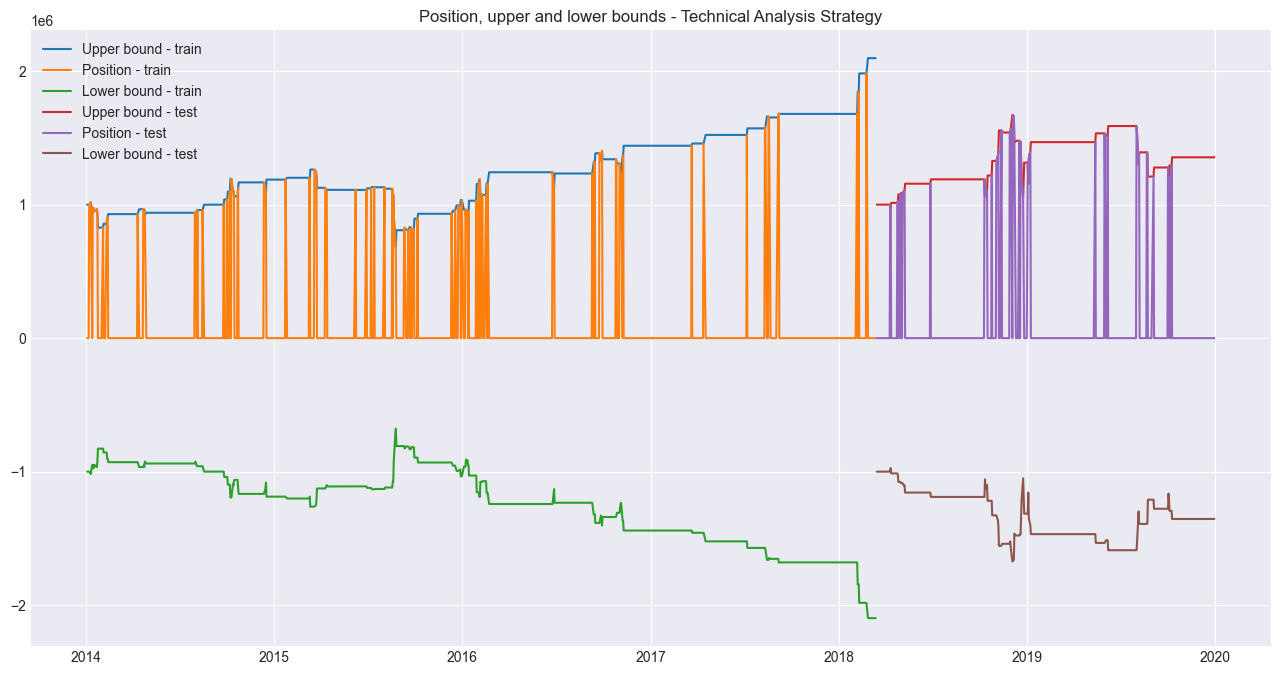

In [9]:
def technical_analysis(df, leverage, initial_cap):
    df['Signal'] = np.where(df['Combined Signal'] == 1, leverage, 0)
    #df['Signal'] = np.where(df['Combined Signal'] == -1, -1, df['Signal'])
    df['Signal'] = np.where(df['Combined Signal'].isnull(), 0, df['Signal'])
    df['Strategy Return'] = df['Signal'].shift(1) * df['Excess Return']
    df['Cash'] = (1+df['Strategy Return']).cumprod() * initial_cap
    df['PnL'] = df['Cash'].diff()
    return df

spy_train = technical_analysis(spy_train, 5, 200000)
spy_test = technical_analysis(spy_test, 5, 200000)

plt.figure(figsize=(16, 8)).patch.set_facecolor('w')
plt.title('Position, upper and lower bounds - Technical Analysis Strategy')
plt.plot(spy_train['Cash']*5, label= 'Upper bound - train')
plt.plot(spy_train['Cash']*spy_train['Signal'], label= 'Position - train')
plt.plot(spy_train['Cash']*-5, label= 'Lower bound - train')
plt.plot(spy_test['Cash']*5, label  = 'Upper bound - test')
plt.plot(spy_test['Cash']*spy_test['Signal'], label= 'Position - test')
plt.plot(spy_test['Cash']*-5, label= 'Lower bound - test')
plt.legend(loc='upper left')

In [10]:
#Calculate the turnover in dollar value traded over time
def turnover(spy):
    turnover_cash = (spy['Cash']*spy['Signal']).diff().abs().sum()
    turnover_units = ((((spy['Cash']*spy['Signal'])/spy['Adj Close']))
                    -((spy['Cash']*spy['Signal'].shift(1)/spy['Adj Close'].shift(1)))).abs().sum()

    print(turnover_cash, turnover_units)

turnover(spy_train)
turnover(spy_test)

137075977.90404522 757965.5166710373
59977771.88139635 234697.1336596306


In [ ]:
def total_pnl(df, initial_cap):
    df['Total strategy return'] = np.where(df['Signal'].shift(1) == 0, df['Daily interest rate'], df['Strategy Return'])
    df['Total strategy cash'] = (1+df['Total strategy return']).cumprod() * initial_cap
    df['Total PnL'] = df['Total strategy cash'].diff()
    return df

spy_train = total_pnl(spy_train, 200000)
spy_test = total_pnl(spy_test, 200000)

/var/folders/qx/wm8zvdn9565d9zck2z8rg25m0000gn/T/ipykernel_45624/2511201456.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spy_train['Capital PnL'] = np.where(spy_train['Signal'].shift(1) == 0, spy_train['Total PnL'], 0)
/var/folders/qx/wm8zvdn9565d9zck2z8rg25m0000gn/T/ipykernel_45624/2511201456.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spy_test['Capital PnL'] = np.where(spy_test['Signal'].shift(1) == 0, spy_test['Total PnL'], 0)


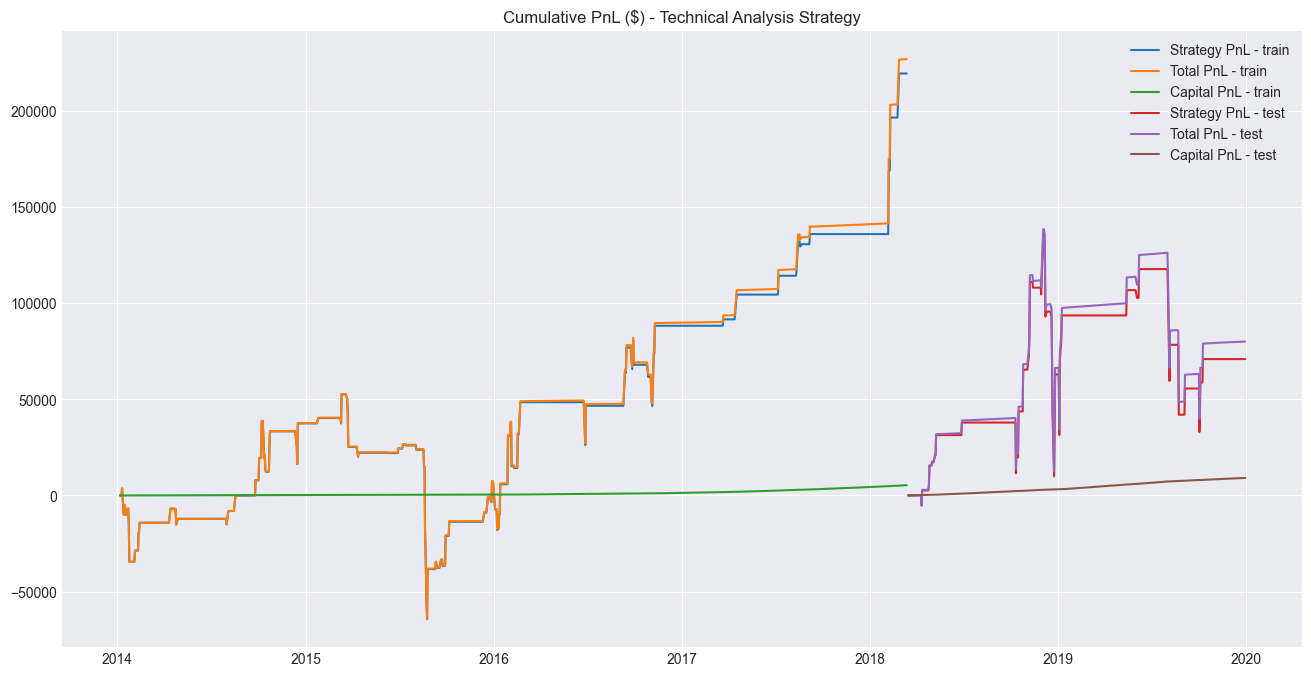

In [12]:
#plot cumulative pnl, total pnl 

#plot cumulative pnl, total pnl 

spy_train['Capital PnL'] = np.where(spy_train['Signal'].shift(1) == 0, spy_train['Total PnL'], 0)
spy_test['Capital PnL'] = np.where(spy_test['Signal'].shift(1) == 0, spy_test['Total PnL'], 0)

plt.figure(figsize=(16, 8)).patch.set_facecolor('w')
plt.title('Cumulative PnL ($) - Technical Analysis Strategy')
plt.plot(spy_train['PnL'].cumsum(), label = 'Strategy PnL - train')
plt.plot(spy_train['Total PnL'].cumsum(), label = 'Total PnL - train')
plt.plot(spy_train['Capital PnL'].cumsum(), label = 'Capital PnL - train')
plt.plot(spy_test['PnL'].cumsum(), label = 'Strategy PnL - test')
plt.plot(spy_test['Total PnL'].cumsum(), label = 'Total PnL - test')
plt.plot(spy_test['Capital PnL'].cumsum(), label = 'Capital PnL - test')
plt.legend()



In [13]:
# compute the Sharpe ratio

def annualised_sharpe_ratio(df):
    return (df['Strategy Return'].mean()*252)/(df['Strategy Return'].std()*np.sqrt(252))

print(annualised_sharpe_ratio(spy_train))
print(annualised_sharpe_ratio(spy_test))

# compute the sortino ratio

def annualised_sortino_ratio(df):
    return (df['Strategy Return'].mean()*252)/(df['Strategy Return'][df['Strategy Return']<0].std()*np.sqrt(252))

print(annualised_sortino_ratio(spy_train))
print(annualised_sortino_ratio(spy_test))

# compute the max drawdown

def max_drawdown(df):
    comp_ret = (df['Strategy Return']+1).cumprod()
    peak = comp_ret.expanding(min_periods=1).max()
    dd = (comp_ret/peak)-1
    return dd.min()

print(max_drawdown(spy_train))
print(max_drawdown(spy_test))
# compute the calmar ratio

def calmar_ratio(df):
    return (df['Strategy Return'].mean()*252)/abs(max_drawdown(df))

print(calmar_ratio(spy_train))
print(calmar_ratio(spy_test))

0.7722894407821362
0.6178466255979593
0.3199817020611512
0.2900803217193563
-0.4628057003948717
-0.3720202002698094
0.4679607808153293
0.6709585834059284


In [16]:
print(spy_test['Strategy Return'].mean(), spy_test['Strategy Return'].std())

0.0009905164546484965 0.025449619047261153


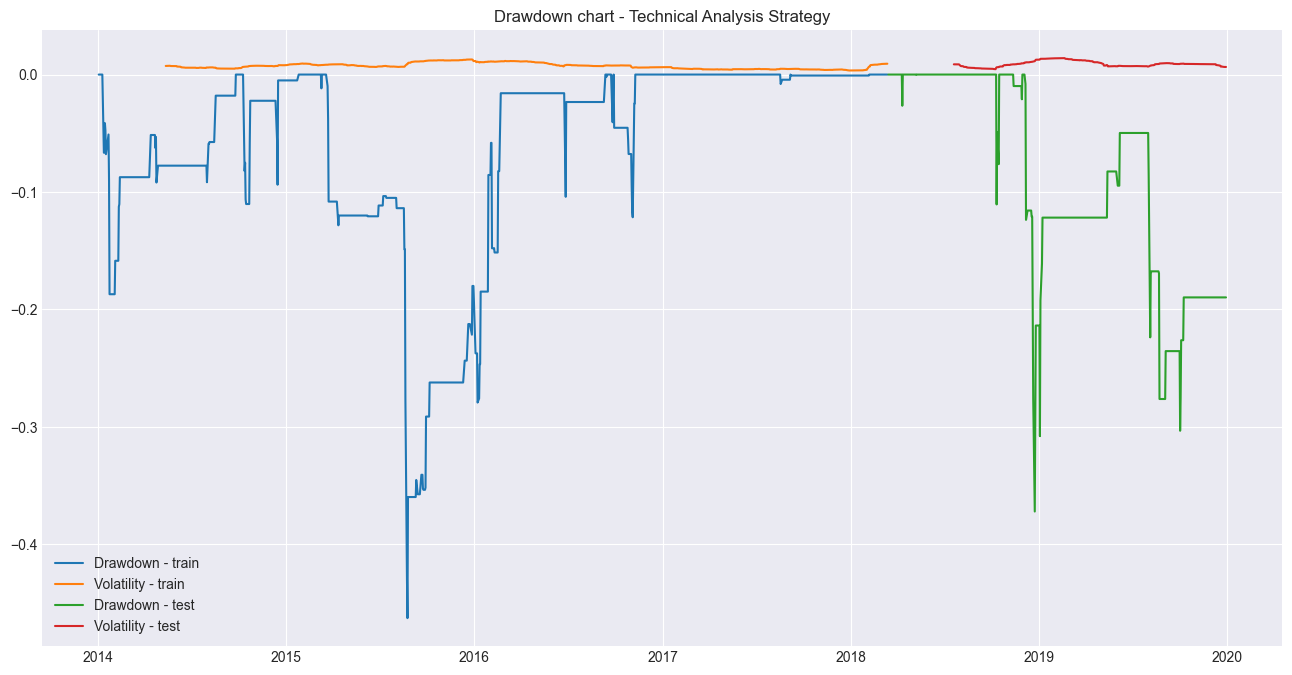

In [14]:
#plot drawdown chart

plt.figure(figsize=(16, 8)).patch.set_facecolor('w')
plt.title('Drawdown chart - Technical Analysis Strategy')
plt.plot(-(spy_train['Cash'].cummax() - spy_train['Cash'])/spy_train['Cash'].cummax(), label = 'Drawdown - train')
plt.plot(spy_train['Return'].rolling(90).std(), label = 'Volatility - train')
plt.plot(-(spy_test['Cash'].cummax() - spy_test['Cash'])/spy_test['Cash'].cummax(), label = 'Drawdown - test')
plt.plot(spy_test['Return'].rolling(90).std(), label = 'Volatility - test')
plt.legend()

In [ ]:
# plot the strategy return

plt.figure(figsize=(16, 8)).patch.set_facecolor('w')
plt.title('Strategy return time series for SPY (2014-01-01 to 2019-12-31)')
plt.plot(spy['Strategy Return'])
plt.plot(spy['Excess Return'])
plt
plt.show()


In [ ]:
print(spy_test['Strategy Return'].mean(), spy_test['Strategy Return'].std())